In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from scipy import stats

import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from teleconnections import build_teleconnection_df
from statistical_tests import independent_ttest, build_zscore_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
start_date = '1979-03-01'
end_date = '2018-05-31'

tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
tele

,AO,PDO,ENSO,SH
date,,,,
1979-03-01 09:00:00,1,-1,0,-1
1979-03-02 09:00:00,1,-1,0,-1
1979-03-03 09:00:00,1,-1,0,-1
1979-03-04 09:00:00,1,-1,0,-1
1979-03-05 09:00:00,1,-1,0,-1
...,...,...,...,...
2018-05-27 09:00:00,1,-1,0,1
2018-05-28 09:00:00,1,-1,0,1
2018-05-29 09:00:00,1,-1,0,1


In [4]:
df_index_djf = select_months(tele, 12, 2)
df_index_mam = select_months(tele, 3, 5)
print('# DJF days: ', len(df_index_djf))
print('# MAM days: ', len(df_index_mam))

# DJF days:  3520
# MAM days:  3680


In [5]:
def ar_daily_df(ssn, nk):
    fname_id = 'HUV500t0120050cor'
    filepath = path_to_out + fname_id + 'hma_AR-types-' + ssn + '.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

In [6]:
df_djf = ar_daily_df(ssn='djf', nk=3)
df_mam = ar_daily_df(ssn='mam', nk=3)

In [7]:
# combine ar df with tele df
print(len(df_djf), len(df_index_djf), len(df_mam), len(df_index_mam))
# join indices with AR count
new_djf = df_djf.join(df_index_djf)
new_mam = df_mam.join(df_index_mam)

3520 3520 3680 3680


### Run zscore difference in proportion tests

In [8]:
zscore_djf = build_zscore_df(new_djf)
zscore_djf

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1  -1.34  0.18
               AR_CAT2   3.09  0.00
               AR_CAT3   3.52  0.00
               AR_ALL    3.39  0.00
PDO            AR_CAT1   0.71  0.48
               AR_CAT2  -0.97  0.33
               AR_CAT3   0.00  1.00
               AR_ALL   -0.16  0.87
ENSO           AR_CAT1   1.31  0.19
               AR_CAT2   0.22  0.82
               AR_CAT3   3.00  0.00
               AR_ALL    2.88  0.00
SH             AR_CAT1  -0.13  0.90
               AR_CAT2   0.79  0.43
               AR_CAT3  -1.95  0.05
               AR_ALL   -0.95  0.34

In [9]:
zscore_mam = build_zscore_df(new_mam)
zscore_mam

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1  -1.77  0.08
               AR_CAT2  -1.09  0.27
               AR_CAT3   5.88  0.00
               AR_ALL    1.73  0.08
PDO            AR_CAT1   2.00  0.05
               AR_CAT2   0.62  0.53
               AR_CAT3   3.94  0.00
               AR_ALL    3.93  0.00
ENSO           AR_CAT1   0.30  0.76
               AR_CAT2   1.64  0.10
               AR_CAT3   3.74  0.00
               AR_ALL    3.32  0.00
SH             AR_CAT1   1.11  0.27
               AR_CAT2  -0.80  0.42
               AR_CAT3  -4.39  0.00
               AR_ALL   -2.39  0.02

### Bar Plot Fractions

In [10]:
cols = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
djf = new_djf.drop(columns=cols)
mam = new_mam.drop(columns=cols)
djf

,AR_CAT,AO,PDO,ENSO,SH
date,,,,,
1979-12-01 09:00:00,3,1,1,0,1
1979-12-02 09:00:00,3,1,1,0,1
1979-12-03 09:00:00,0,1,1,0,1
1979-12-04 09:00:00,0,1,1,0,1
1979-12-05 09:00:00,0,1,1,0,1
...,...,...,...,...,...
2018-02-24 09:00:00,0,-1,-1,-1,1
2018-02-25 09:00:00,0,-1,-1,-1,1
2018-02-26 09:00:00,1,-1,-1,-1,1


In [11]:
results_test = []
for i, df in enumerate([djf, mam]):
    test_df = df
    # count the frequency of each AR type based on phase conditions
    test = test_df.groupby(['AR_CAT']).agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    # get the frequency value
    test2 = test.div(len(test_df)) * 100

    # put into a new dataframe and reset the index
    data=pd.DataFrame(test2)
    data = data.reset_index()

    # melt the dataframe to make it tidy
    results = pd.melt(data, id_vars=['level_0', 'level_1'], value_vars=['AO', 'PDO', 'ENSO', 'SH'],
                      var_name='teleconnection', value_name='frequency')

    # drop rows where level_0 = 0
    # or where there is no AR
    results_test.append(results[results.level_0 != 0])

In [12]:
# put into a new dataframe and reset the index
data=pd.DataFrame(zscore_mam)
data = data.reset_index()
data

,Teleconnection,AR Type,zstat,pval
0,AO,AR_CAT1,-1.77,0.08
1,AO,AR_CAT2,-1.09,0.27
2,AO,AR_CAT3,5.88,0.00
3,AO,AR_ALL,1.73,0.08
4,PDO,AR_CAT1,2.00,0.05
5,PDO,AR_CAT2,0.62,0.53
6,PDO,AR_CAT3,3.94,0.00
7,PDO,AR_ALL,3.93,0.00
8,ENSO,AR_CAT1,0.30,0.76
9,ENSO,AR_CAT2,1.64,0.10


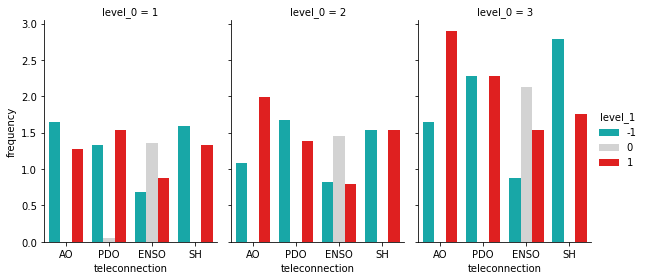

In [13]:
flatui = ['c', 'lightgrey', 'red']
sns.catplot(x="teleconnection", y='frequency', hue="level_1", col="level_0", 
            data=results_test[0], kind="bar", height=4, aspect=.7, palette=flatui)

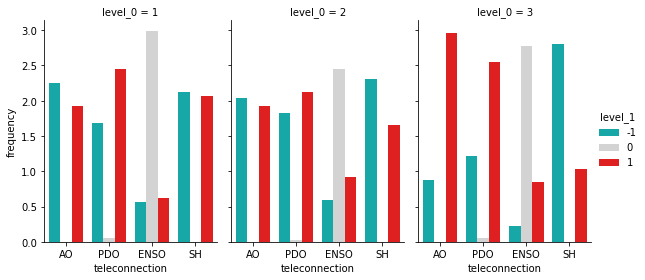

In [14]:
sns.catplot(x="teleconnection", y='frequency', hue="level_1", col="level_0", 
            data=results_test[1], kind="bar", height=4, aspect=.7, palette=flatui)

In [20]:
artype = [1, 2, 3]
for i, (p, ar) in enumerate(zip(np.arange(3, 6), artype)):
    print(i, p, ar)

0 3 1
1 4 2
2 5 3


/home/nash/DATA/repositories/AR_types/figs/zscore_barplot.png


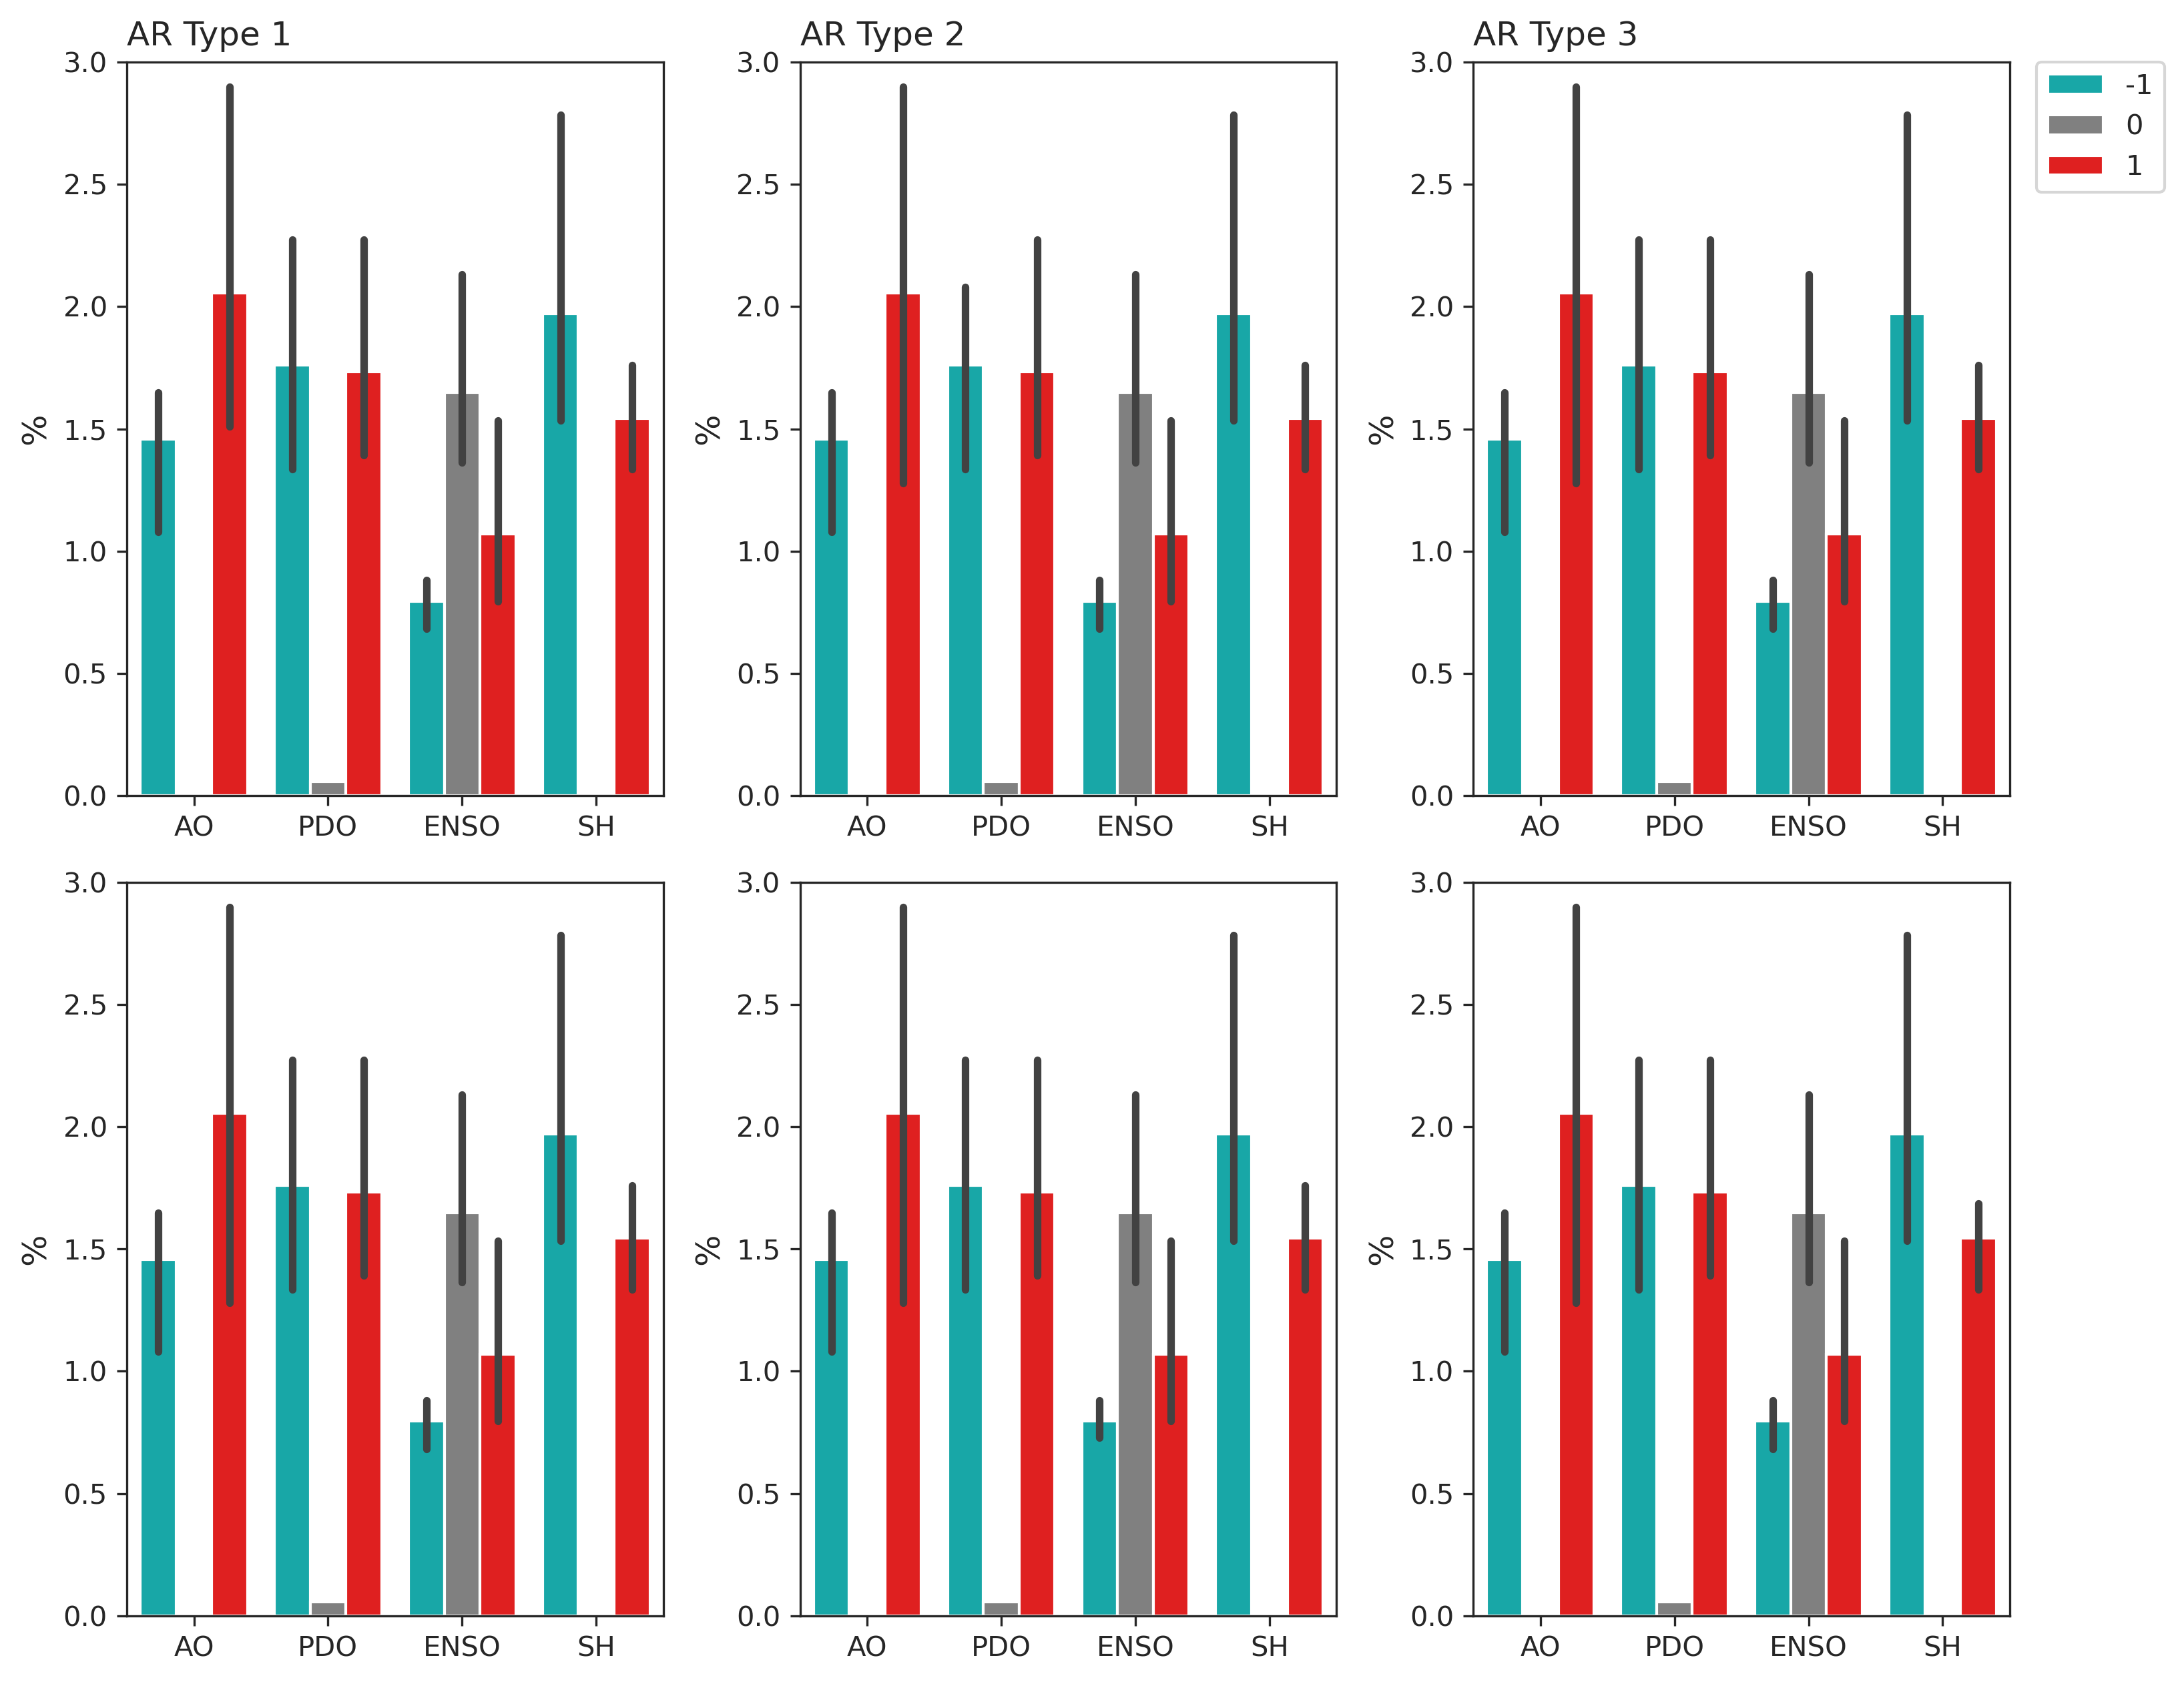

<Figure size 3300x2550 with 0 Axes>

In [27]:
fname = path_to_figs + 'zscore_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((11.0,8.5))
fig.dpi = 300
nrows = 2
ncols = 3
nplots=nrows*ncols

artype = [1, 2, 3]
typ_label = ['AR Type 1', 'AR Type 2', 'AR Type 3']
flatui = ['c', 'grey', 'red', ]
ssn_lst = ['DJF', 'MAM']

#### DJF Plots
for i, (p, ar) in enumerate(zip(np.arange(0, 3), artype)):
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True)
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('%', fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)
    ax.set_title(typ_label[i], loc='center') 

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
### MAM Plots
for i, (p, ar) in enumerate(zip(np.arange(3, 6), artype)):
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.level_0 == ar]
    g = sns.barplot(x=data['teleconnection'], y=data['frequency'], hue=data["level_1"],
                data=df, palette=flatui, dodge=True)
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('%', fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 3)

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### Composite Plots

In [ ]:
# Select lat/lon grid
lonmin = -180
lonmax = 180
latmin = 0
latmax = 90

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# # open HUV data
filepath_pattern = path_to_data + 'ERA5/huv/anomalies/daily_filtered_anomalies_*.nc'  
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
var_dict = {'H': (['time', 'lat', 'lon'], f2['z'].values/(9.80665)), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f2['u'].values),
            'V': (['time', 'lat', 'lon'], f2['v'].values)}
ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f2.time.values),
                        'lat': (['lat'], f2.latitude.values),
                        'lon': (['lon'], f2.longitude.values)})

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds

In [ ]:
# Trim date range
start_date = '1979-03-01'
end_date = '2018-05-31'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select months
mon_s = 3
mon_e = 5
if mon_s > mon_e:
    idx = (ds.time.dt.month >= mon_s) | (ds.time.dt.month <= mon_e)
else:
    idx = (ds.time.dt.month >= mon_s) & (ds.time.dt.month <= mon_e)
    
ds = ds.sel(time=idx)


# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
cols = ['AR_CAT', 'ao', 'pdo', 'enso', 'sh']
for i, col in enumerate(cols):
    ds[col] = ('time', new_mam[col])

ds = ds.set_coords(tuple(cols))
ds

In [ ]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set up projection
mapcrs = ccrs.NorthPolarStereo()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # cmap with white in the middle
# n=50
# x = 0.25
# lower = plt.cm.seismic(np.linspace(0, x, n))
# white = plt.cm.seismic(np.ones(100)*0.25)
# upper = plt.cm.seismic(np.linspace(1-x, 1, n))
# colors = np.vstack((lower, white, upper))
# tmap = mpl.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)

In [ ]:
# https://stackoverflow.com/questions/41806285/how-to-change-colorbars-color-in-some-particular-value-interval
import matplotlib.colors

n=50
x = 0.25
lower = plt.cm.seismic(np.linspace(0, x, n))
print(np.linspace(0, x, n))
white = plt.cm.seismic(np.ones(100)*0.25)
upper = plt.cm.seismic(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('terrain_map_white', colors)

x = np.linspace(0,10)
X,Y = np.meshgrid(x,x)
z = np.sin(X) * np.cos(Y*0.4)

fig, ax = plt.subplots()
im = ax.imshow(z, cmap=tmap)    
plt.colorbar(im)

plt.show() 

In [ ]:
filepath = path_to_figs + 'composites/teleconnections/positive_teleconnections_mam' + '.png'    
nrows = 5
ncols = 4

cols = ['ao', 'pdo', 'enso', 'sh']
plt_lbls = ['AO', 'PDO', 'ENSO', 'SH']
row_lbl1 = ['All Days', '', '', '']
row_lbl2 = ['AR Days', '', '', '']
row_lbl3 = ['AR Type 1', '', '', '']
row_lbl4 = ['AR Type 2', '', '', '']
row_lbl5 = ['AR Type 3', '', '', '']

cmap = cmo.balance

# Create figure
fig = plt.figure(figsize=(10,15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.10, cbar_size='2%',label_mode='',
                direction='row')

##############################
########## ALL DAYS ##########
##############################
for k, (ax, tele) in enumerate(zip(axgr[0:4], cols)): 
    # all days positive teleconnection
    idx = (ds[tele] == 1)
    data = ds.sel(time=idx).mean('time')
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values 
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Contour Filled
    hgts = data.H.values
    cflevs = np.arange(-90, 95, 15)
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    ax.set_title(plt_lbls[k], fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl1[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
#############################
########## AR DAYS ##########
#############################
for k, (ax, tele) in enumerate(zip(axgr[4:8], cols)):     
    # all ar days positive teleconnection
    idx = (ds['AR_CAT'] > 0) & (ds[tele] == 1)
    data = ds.sel(time=idx).mean('time')
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Contour Filled
    hgts = data.H.values
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    # Row labels
    ax.text(-0.07, 0.55, row_lbl2[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
#############################
########## AR CAT 1 #########
#############################
for k, (ax, tele) in enumerate(zip(axgr[8:12], cols)):                   
    # ar categories positive teleconnection              
    idx = (ds['AR_CAT'] == 1) & (ds[tele] == 1)
    data = ds.sel(time=idx).mean('time')
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Contour Filled
    hgts = data.H.values
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    # Row labels
    ax.text(-0.07, 0.55, row_lbl3[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
#############################
########## AR CAT 2 #########
#############################
for k, (ax, tele) in enumerate(zip(axgr[12:16], cols)):                   
    # ar categories positive teleconnection              
    idx = (ds['AR_CAT'] == 2) & (ds[tele] == 1)
    data = ds.sel(time=idx).mean('time')
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Contour Filled
    hgts = data.H.values
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    # Row labels
    ax.text(-0.07, 0.55, row_lbl4[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
#############################
########## AR CAT 3 #########
#############################
for k, (ax, tele) in enumerate(zip(axgr[16:], cols)):                  
    # ar categories positive teleconnection              
    idx = (ds['AR_CAT'] == 3) & (ds[tele] == 1)
    data = ds.sel(time=idx).mean('time')
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Contour Filled
    hgts = data.H.values
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    # Row labels
    ax.text(-0.07, 0.55, row_lbl5[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
                  
# # Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both', spacing='uniform')
cb.set_label('m')
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

In [ ]:
# # Compute composites of each AR type
# era_ar_comp = era_ar_lag.groupby('ar').mean('time')
# era_ar_comp1 = era_ar_lag2.groupby('ar').mean('time')

d = []
d2 = []

artype_lst = [1, 2, 3] # type 1, type 2, type 3

for k, ar_type in enumerate(artype_lst):
    # conditions for El Nino
    idx_nino = (era_ar.enso == 1) & (era_ar.ar == ar_type)
    nino = era_ar.sel(time=idx_nino).mean('time')
    
    # conditions for La Nina
    idx_nina = (era_ar.enso == 2) & (era_ar.ar == ar_type)
    nina = era_ar.sel(time=idx_nina).mean('time')
    
    # TO DO: ADD SIGNIFICANCE TEST
    
    # subtract NINA from NINO
    d.append(nino - nina)
    
    ### Repeat for prec ds
    # conditions for El Nino
    idx_nino = (era_ar2.enso == 1) & (era_ar2.ar == ar_type)
    nino = era_ar2.sel(time=idx_nino).mean('time')
    
    # conditions for La Nina
    idx_nina = (era_ar2.enso == 2) & (era_ar2.ar == ar_type)
    nina = era_ar2.sel(time=idx_nina).mean('time')
    
    # TO DO: ADD SIGNIFICANCE TEST
    
    # subtract La Nina from El Nino
    d2.append(nino - nina)
    



In [ ]:
# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 3,
            'artype_lst': [2, 0, 1],
            'panel': '9pan'}

panel_dict = panel_9

In [ ]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

In [ ]:
fig_dict = panel_dict
filepath = path_to_figs + 'composites/teleconnections' + '/' + 'ENSO_all_vars_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'    
nrows = fig_dict['nrows']
ncols = fig_dict['ncols']
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:3], artype_lst)):
    data = d[ar_type]
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[3:6], artype_lst)):
    data = d[ar_type]
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr[6:], artype_lst)):
    data = d2[ar_type]
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(0, 8, 1)
#     cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    if plot_dict['anom'] == 'anom':
        cmap = cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None)
    if plot_dict['anom'] == 'nanom':
        cmap = plot_dict['cmap']
    prec = data.prec.values
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
